## make sure the output contains the north arrow and scale and legend!



**HINT**

combine stablity(?) and accsessibility 

decide how to deal with the data

- first step: create network dataset
- second: overlay polygon and network
- third: 5 discrete travel time decide by yourself, same / differ in health and firestation
	explain why you use 
- generate isocrome map, add polygon 
- how you want to weight differenct accsibilty zone(polygon)
- next: example and summarize 
	think about how: neighbor area?(50%neighbor in 5-min zone, 50% in 10-min zone)-> compsoite weight in each neighborhood
	sort DESC;

*JUSTIFY WHAT YOU CHOOSE IN PDF*

think about the lab3 first and do some steps,
the implementation will be in 1h

In this lab, you will map the best and worst neighborhoods to live in using accessibility to two types of amenities: community health facilities and fire stations as criteria.

You are provided with three basic geospatial datasets:

1. Atlanta neighborhood statistical areas (polygon shapefile)

2. Community health facilities (point shapefile)

3. Fire stations (point shapefile)



Please follow the main steps below to find out which neighborhood is the best to live in and which is the worst.



## 1.Create a drive network model for the city of Atlanta. (5 pts)

Plot a map of the network you built spatially overlaid on top of the neighborhoods.

#todo: overlay on top of the neighborhoods


In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
import sklearn as sk
import pandas as pd

%matplotlib inline
ox.__version__

'1.6.0'

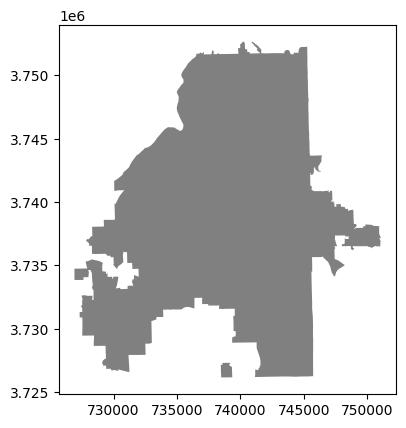

In [23]:
atlanta = ox.geocode_to_gdf("Atlanta, Georgia, USA")
atlanta_proj = ox.project_gdf(atlanta, to_crs=32616)
ax = atlanta_proj.plot(fc="gray", ec="none")


In [24]:
G = ox.graph_from_polygon(atlanta.iloc[0]['geometry'], network_type="drive")
# around 24 seconds to run this cell

In [3]:
# save graph as a geopackage
ox.save_graph_geopackage(G, filepath="G.gpkg")

# save/load graph as a graphml file
filepath = "G.graphml"
ox.save_graphml(G, filepath)


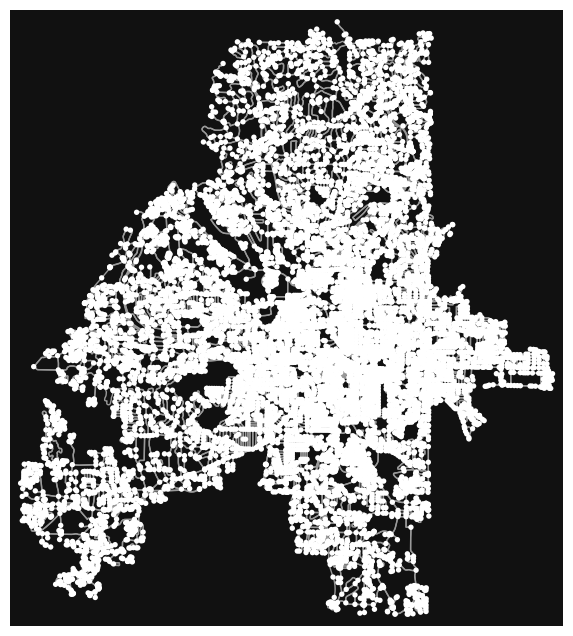

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [18]:
filepath = "G.graphml"
G = ox.load_graphml(filepath)
ox.plot_graph(G)
# around 5 sec to run this cell

In [12]:
# find the centermost node
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes["geometry"].unary_union.centroid.xy
center_node = ox.distance.nearest_nodes(G, x[0], y[0])


In [20]:

# Project graph to UTM
G = ox.project_graph(G)

In [15]:
# print graph summary stats
print(ox.basic_stats(G, area=atlanta_proj.unary_union.area))


{'n': 12800, 'm': 33390, 'k_avg': 5.2171875, 'edge_length_total': 5161534.597999995, 'edge_length_avg': 154.583246421084, 'streets_per_node_avg': 2.87734375, 'streets_per_node_counts': {0: 0, 1: 1854, 2: 99, 3: 8692, 4: 2080, 5: 68, 6: 7}, 'streets_per_node_proportions': {0: 0.0, 1: 0.14484375, 2: 0.007734375, 3: 0.6790625, 4: 0.1625, 5: 0.0053125, 6: 0.000546875}, 'intersection_count': 10946, 'street_length_total': 2844800.520000012, 'street_segment_count': 18296, 'street_length_avg': 155.48756668124247, 'circuity_avg': 1.0692219761674553, 'self_loop_proportion': 0.013882815916047224, 'node_density_km': 36.76137412676308, 'intersection_density_km': 31.43671884308974, 'edge_density_km': 14823.836283227301, 'street_density_km': 8170.216893103952}


In [55]:
# turn G to weighted graph
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [13]:
ox.save_graph_geopackage(G, filepath="G_final.gpkg")


<Axes: >

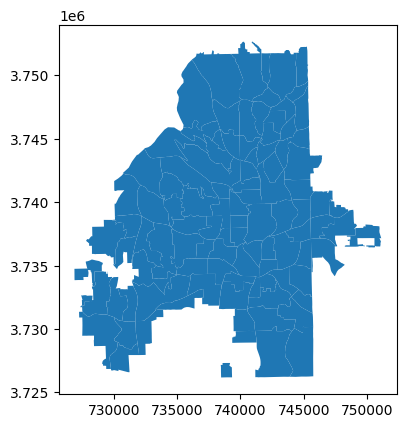

In [4]:
neighborhoods = gpd.read_file("lab3_data/City_of_Atlanta_Neighborhood_Statistical_Areas")
neighborhoods_proj = neighborhoods.to_crs(32616)
neighborhoods_proj.plot()

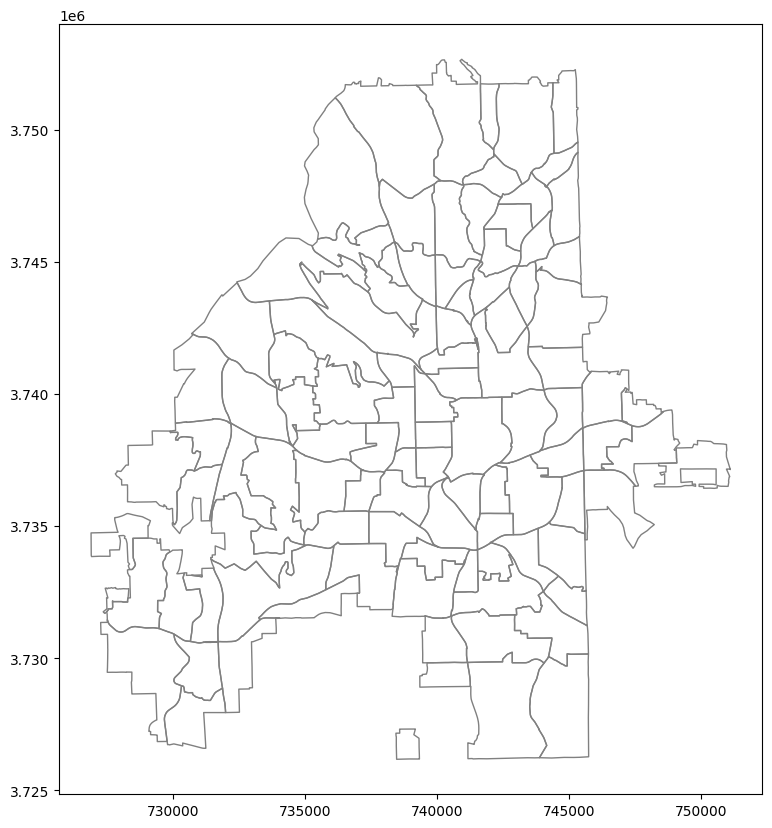

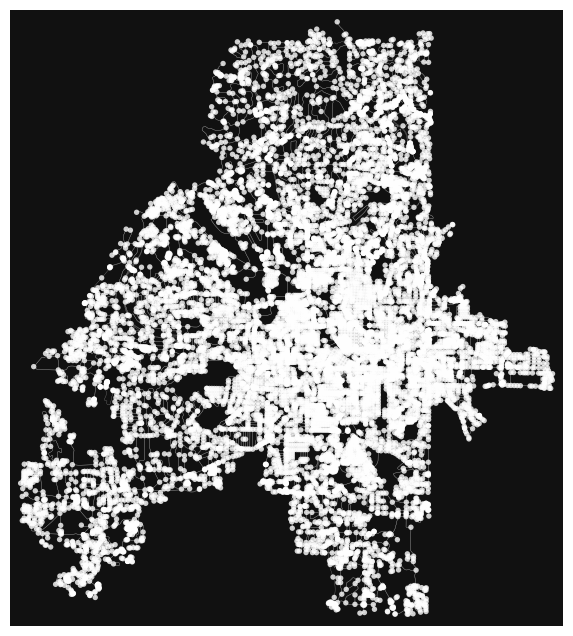

In [8]:

# plot g and neighborhoods in the same fig


fig, ax = plt.subplots(figsize=(10,10))
neighborhoods_proj.plot(ax=ax, facecolor="none", edgecolor="gray")
fig, ax = ox.plot_graph(
    G,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)


In [26]:
# Given a graph, generate a dataframe (df)
# representing all graph nodes
def create_nodes_df(G):
    # first make a df from the nodes
    # and pivot the results so that the 
    # individual node ids are listed as
    # row indices
    nodes_df = pd.DataFrame(G.nodes).T
    
    # preserve these indices as a column values, too
    nodes_df['id'] = nodes_df.index
    # and cast it as an integer
    nodes_df['id'] = nodes_df['id'].astype(int)
    
    return nodes_df

nodes_df = create_nodes_df(G)


2. Generate accessibility zones using 5 discrete travel time thresholds for health facilities and fire stations. (3 pts)

Plot an accessibility map to health stations
Plot an accessibility map to fire stations


In [38]:
# plot an accessibility map to health stations

# read the health stations
health_path = 'lab3_data/Community_Health_Facilities'
health = gpd.read_file(health_path)
health = health.to_crs(32616)
health_proj = health.to_crs(32616)
health_proj.head()


,OBJECTID,ID,SECCLASS,NAME,TELEPHONE,ADDRESS,ADDRESS2,CITY,STATE,ZIP,...,GEOPREC,PHONELOC,QC_QA,STATE_ID,GlobalID,created_us,created_da,last_edite,last_edi_1,geometry
0,172,10417213,UNCLASSIFIED,SHEPHERD CENTER,404-352-2020,2020 PEACHTREE ROAD NORTHWEST,NaN,ATLANTA,GA,30309,...,ONENTITY,YES,TGS,6473,{E3F90597-0954-4BCC-AAD8-E44946C85C96},SDE,2015-12-30,SDE,2015-12-30,POINT (741172.388 3744468.676)
1,173,10417063,UNCLASSIFIED,CHILDREN'S HEALTHCARE OF ATLANTA AT HUGHES SPA...,404-785-9500,35 JESSE HILL JUNIOR DRIVE SOUTHEAST,NaN,ATLANTA,GA,30303,...,ONENTITY,YES,TGS,6928,{9CFB3F04-D6AA-4678-8BAF-5F15224CDCBB},SDE,2015-12-30,SDE,2015-12-30,POINT (742503.804 3738225.097)
2,174,10417233,UNCLASSIFIED,GRADY MEMORIAL HOSPITAL,404-616-1000,80 JESSE HILL JUNIOR DRIVE SOUTHEAST,NaN,ATLANTA,GA,30303,...,ONENTITY,YES,TGS,6929,{DC1B4E2C-53C7-4D3D-95FC-CBB055085EE2},SDE,2015-12-30,SDE,2015-12-30,POINT (742486.869 3738027.642)
3,175,10417210,UNCLASSIFIED,SUMMITRIDGE PSYCHIATRIC HOSPITAL,770-822-2200,250 SCENIC HIGHWAY,NaN,LAWRENCEVILLE,GA,30045,...,ONENTITY,YES,TGS,6464,{84BDB715-97D3-4E67-A969-1D60C81D929B},SDE,2015-12-30,SDE,2015-12-30,POINT (778235.774 3759851.198)
4,176,10417065,UNCLASSIFIED,SAINT JOSEPH'S HOSPITAL OF ATLANTA,404-851-7120,5665 PEACHTREE DUNWOODY ROAD,NaN,ATLANTA,GA,30342,...,ONENTITY,YES,TGS,6924,{D9C51F5A-35A6-4ABB-9E56-D0490C0D3FE9},SDE,2015-12-30,SDE,2015-12-30,POINT (745020.824 3755469.486)


In [21]:

# turn reading the shp folder and project into a function
def read_and_project(folder_path, crs=32616):
	# output_name is the name of return variable
	gdf = gpd.read_file(folder_path)
	gdf = gdf.to_crs(crs)
	output_gdf_name = gdf.to_crs(crs)
	print("The projection of the input data is: ", gdf.crs)
	print("read and projected the data successfully!", gdf.head(3))
	return gdf


In [9]:
# read the fire stations
fire_path = 'lab3_data/Fire_Stations'
fire = gpd.read_file(fire_path)
fire.head()
fire = fire.to_crs(32616)
fire_proj = fire.to_crs(32616)


In [11]:
# specify travel time thresholds in minutes
# trip_times = [5, 10, 15, 20, 25]  # in minutes
trip_times = [15, 20, 25, 30, 35]  # in minutes


In [12]:

# calcutate the accessibility
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)
iso_colors


['#0d0887', '#7e03a8', '#cc4778', '#f89540', '#f0f921']

In [14]:
# build the isochrone polygons based on fire station
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, n=fire_proj,radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
        
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

TypeError: unhashable type: 'GeoDataFrame'

In [17]:
# Given a graph, generate a dataframe (df)
# representing all graph nodes
def create_nodes_df(G):
    # first make a df from the nodes
    # and pivot the results so that the 
    # individual node ids are listed as
    # row indices
    nodes_df = pd.DataFrame(G.node).T
    
    # preserve these indices as a column values, too
    nodes_df['id'] = nodes_df.index
    # and cast it as an integer
    nodes_df['id'] = nodes_df['id'].astype(int)
    
    return nodes_df

nodes_df = create_nodes_df(G)

AttributeError: 'MultiDiGraph' object has no attribute 'node'


3. Add a weight field to the attribute tables representing an ordinal ranked distance away from the facilities and combine the weights together. (3 pts)
Plot a map showing the combined weights


In [14]:

# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute

for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

for i, j, data in G.edges.data():
    print(i, j, data)
    break


68145665 462857057 {'osmid': 9167391, 'name': 'Flat Shoals Road Southeast', 'highway': 'tertiary', 'oneway': False, 'reversed': True, 'length': 74.605, 'speed_kph': 52.0, 'travel_time': 5.2}


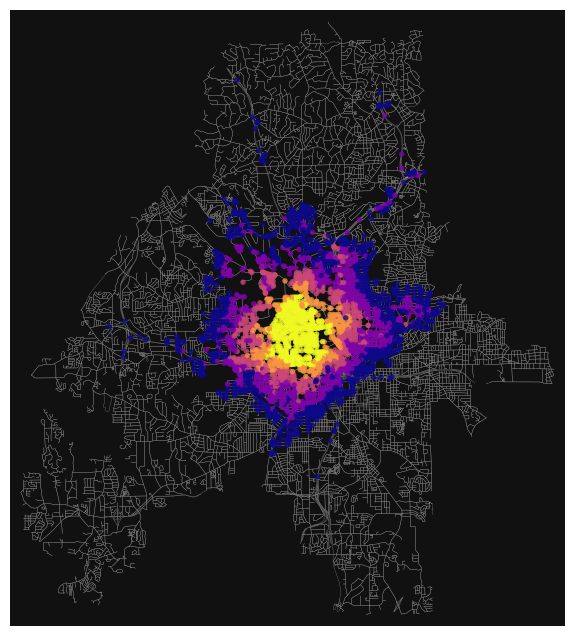

In [28]:
# fixme!
# todo: reference https://github.com/eemilhaa/walkability-analysis/blob/main/routing_analysis.ipynb to solve this accesisbility problem

# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
        
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

In [29]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

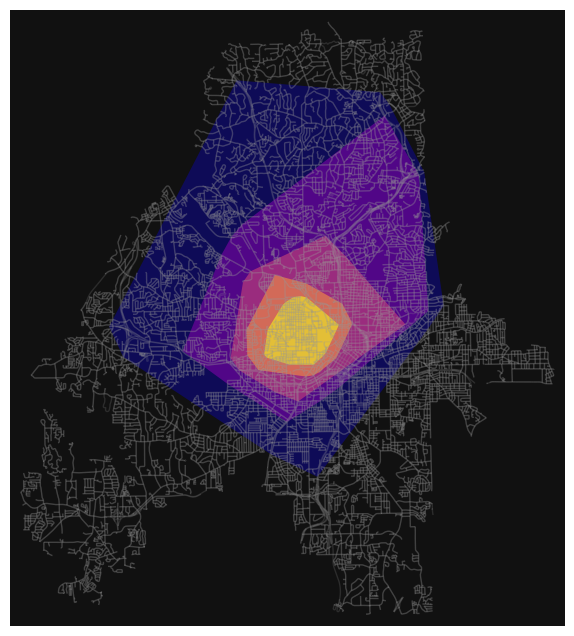

In [30]:
# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()

In [31]:
def make_iso_polys(G, edge_buff=0.0001, node_buff=0.0001, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

In [34]:
# make the isochrone polygons
isochrone_polys = make_iso_polys(G, edge_buff=0.0001, node_buff=0.0001, infill=True)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

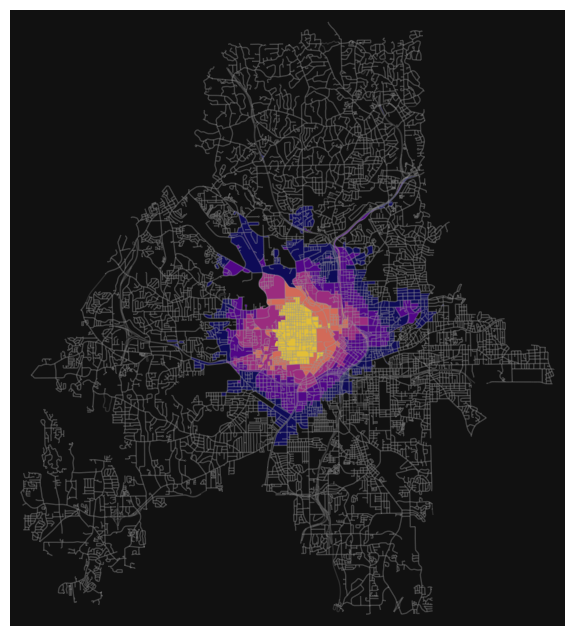

In [35]:
# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()


4. Overlay neighborhood polygons, calculate the average weight for each neighborhood, and find out the best and worst neighborhoods to live in based on accessibility to health facilities and fire stations. (4 pts)

Create a choropleth map showing the average weights of the neighborhoods.
Which neighborhood has the highest weight?
Which neighborhood has the lowest weight?
Please remember that all the maps you create should have TODALS (Title, Orientation, Date, Author, Legend, Scale)

Please upload a single PDF file containing your maps and responses to the questions in this lab.

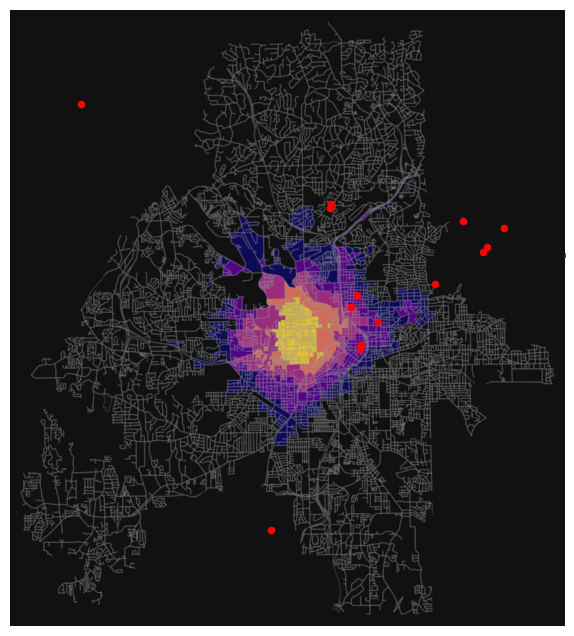

In [39]:
# plot health stations on the accessibility map
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
health_proj.plot(ax=ax, color="red", markersize=20)
plt.show()

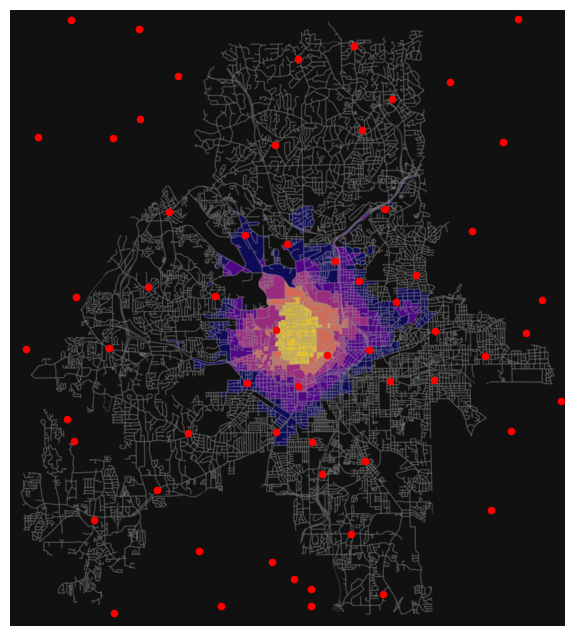

In [45]:
# plot fire stations on the accessibility map
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
fire_proj.plot(ax=ax, color="red", markersize=20)
plt.show()	

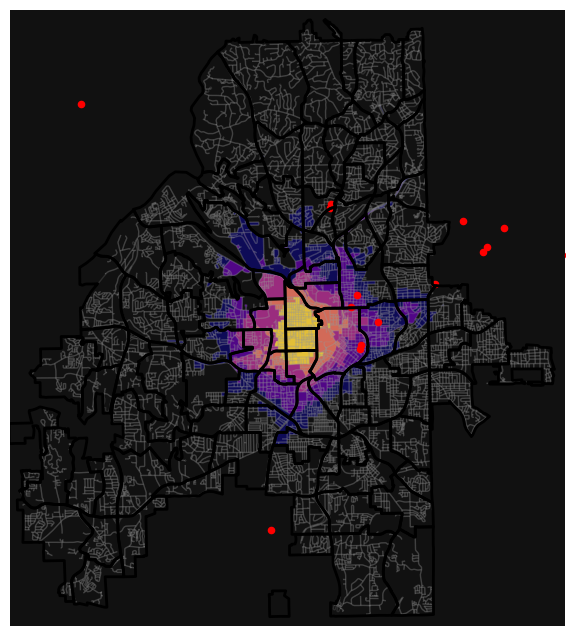

In [49]:
# overlay the neighborhoods to the health accessibility map
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
health_proj.plot(ax=ax, color="red", markersize=20)
neighborhoods_proj.plot(ax=ax, color="none", edgecolor="black", linewidth=2)
plt.show()

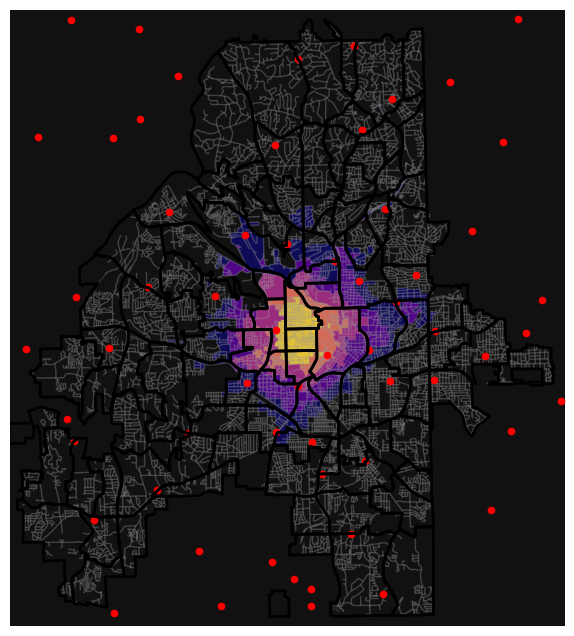

In [50]:
# overlay the neighborhoods to the fire accessibility map
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
fire_proj.plot(ax=ax, color="red", markersize=20)
neighborhoods_proj.plot(ax=ax, color="none", edgecolor="black", linewidth=2)
plt.show()